The goal of this notebook is to write and tune the code for a general reference trajectory function for the centerline of an anguilliform swimmer

The general form of an anguilliform gait is given by
$$ h(z,t) = a(z) sin(kz - \omega t)$$

where $z$ is the axial (swimming) direction measured along the fish axis from tip of th fish's head; $h(z,t)$ is tha lateral excusion of the body at titme $t$; $a(z)$ is the ampligtude envelope of the lateral motion as a functino of $z$; $k$ is the wave number of the body uindulations that corresponds to a awavelength $\lambda$; and $\omega$ is the angular frequency.

For anguilliform kinematics, the amplitude engelvope is approximated by an exponential function 
$$a(z) = a_{max} e^{z-1}$$

where $a_{max}$ is the tail-beat amplitude and is set equal to 0.1 (Hultmakr et al., 2007).

In [26]:
 # imports
 #!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

from util import *
config = dotenv_values(".env")

In [27]:
# Function to provide coordinates of discretized centerline at a given time
def generateCenterlineCoords(time,numPoints=100,a_max=0.1,l=1,k=10,omega=7,x_shift = 0,z_shift = 0):
    # Generate x coordinates
    x = np.linspace(0,l,numPoints)
    # Generate z coordinates 
    z = a_max*np.exp((x)/l-1)*np.sin(k*(x)/l-omega*time)
    # z = z-z[0]
    return x+x_shift,z+z_shift


In [28]:
# Function to provide coordinates of discretized centerline at a given time
def generateReferenceCoords(time,numPoints=20,a_max=0.1,l=1,k=10,omega=7,x_shift = 0,z_shift = 0):
    # Generate 10 times number of x coordinates as desired points
    x = np.linspace(0,l,numPoints*100)
    dx = x[1]-x[0]
    # Compute integrand of arc length integral
    integrand = np.sqrt(1+(a_max/l*(np.exp(x/l-1)*(k*np.cos(k/l*x+omega*time)-np.sin(-k/l*x+omega*time))))**2)
    # Use first order quadrature to compute integral
    integrand = integrand*dx
    integrand = np.cumsum(integrand)
    # Find where the integral is closest to the desired arc length
    larc_des = np.linspace(0,l,numPoints)
    x_ref = np.zeros(numPoints)
    z_ref = np.zeros(numPoints)
    for i in range(numPoints):
        idx = np.argmin(np.abs(integrand-larc_des[i]))
        x_ref[i] = x[idx]
        # Compute z value at this point
        z_ref[i] = a_max*np.exp(x[idx]/l-1)*np.sin(k*x[idx]/l-omega*time)
    # z = z-z[0]
    return x_ref+x_shift,z_ref+z_shift


(-0.5, 0.5)

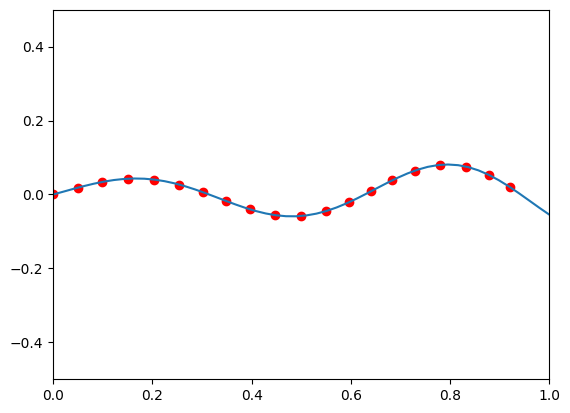

In [29]:
# Plot centerline coordinates at a given time
t = 0
x,z = generateCenterlineCoords(t,50)
x_ref,z_ref = generateReferenceCoords(t,20)
plt.plot(x,z)
plt.scatter(x_ref,z_ref,color='red')
# Plot limits
plt.xlim(0,1)
plt.ylim(-0.5,0.5)

Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/visualizations/referenceCenterline.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/visualizations/referenceCenterline.mp4



t:   1%|          | 3/300 [00:00<00:11, 25.33it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/visualizations/referenceCenterline.mp4


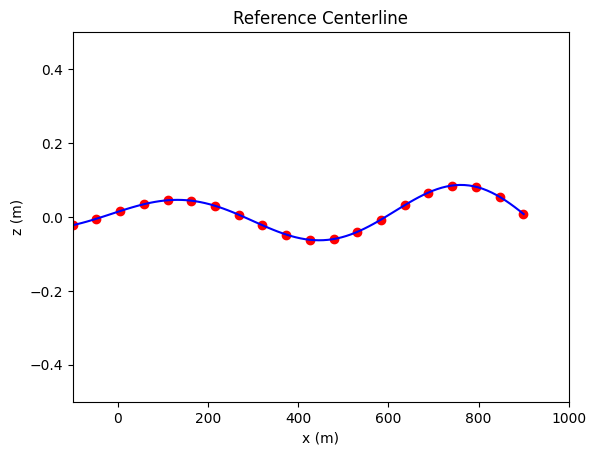

In [30]:
# Make video of centerline over a couple cycles
# Configure save path for video
savePath = config["currentDirectory"] +"data/visualizations/"
saveName = "referenceCenterline.mp4"
numFrames = 100
fps = 30
duration = numFrames/fps


# Set up figure for animation
fig, ax = plt.subplots()


# Animation callback
def animate(t):
    # Get frame index
    i = int(round(t*fps))
    # Compute centerline
    x,z = generateCenterlineCoords(t,100,l=1000,x_shift=-100)
    x_ref,z_ref = generateReferenceCoords(t,20,l=1000,x_shift=-100)
    # Plot mesh points from original centerline
    ax.clear()
    ax.plot(x,z,color='blue')
    ax.scatter(x_ref,z_ref,color='red')
    ax.set_xlim(-100,1000)
    ax.set_ylim(-0.5,0.5)
    # ax.set_aspect('equal')
    ax.set_title("Reference Centerline")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return mplfig_to_npimage(fig)

# Create animation
animation = VideoClip(animate, duration=duration)
animation.write_videofile(savePath+saveName, fps=fps)
    
